In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import random

from models.lstm import LSTMRegressor
from models.kan_encoder import KANEncoder
from utils.stock_data import get_data_loaders, StockIndex
from utils.early_stopping import EarlyStopping
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [2]:
window_size = 7
SEED=42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

BEST_LSTM_PARAMS = {
    StockIndex.NVDA: {
        "hidden_dim": 480,
        "num_layers": 3,
        "dropout": 0.30769150214017327,
        "batch_size": 64,
        "lr": 0.0003303714700935045
    },
    StockIndex.AAPL: {
        "hidden_dim": 288,
        "num_layers": 2,
        "dropout": 0.18150920736987075,
        "batch_size": 16,
        "lr": 0.005275140914212679
    },
    StockIndex.KO: {
        "hidden_dim": 96,
        "num_layers": 2,
        "dropout": 0.29591485727946204,
        "batch_size": 16,
        "lr": 0.0014637258293838983
    }
}

BEST_KAN_PARAMS = {
    StockIndex.NVDA: {
        "kan_hidden_dim": 5,
        "encoded_dim": 16,
        "grid": 21,
        "k": 3,
        "lambda_reg": 0.00013721431062684356,
        "lamb_entropy": 1.1269861289727312,
        "lamb_l1": 1.967354782571587,
        "lr": 0.0003191782838449607
    },
    StockIndex.AAPL: {
        "kan_hidden_dim": 8,
        "encoded_dim": 4,
        "grid": 7,
        "k": 3,
        "lambda_reg": 0.000263548291555308,
        "lamb_entropy": 1.8190705696118517,
        "lamb_l1": 0.8206103902494236,
        "lr": 0.009807310647289798
    },
    StockIndex.KO: {
        "kan_hidden_dim": 8,
        "encoded_dim": 8,
        "grid": 9,
        "k": 3,
        "lambda_reg": 2.931556418816886e-05,
        "lamb_entropy": 0.5450533365756015,
        "lamb_l1": 0.1303348839163485,
        "lr": 0.00019842586119441056
    }
}

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## Training KAN-Fixed LSTM for each stock ##

### NVDIA ###
Avg Val Loss in Tuning 0.004401

In [12]:
stock = StockIndex.NVDA
lstm_params = BEST_LSTM_PARAMS[stock]
kan_params = BEST_KAN_PARAMS[stock]
train_dl, test_dl, scalers = get_data_loaders(stock, window_size, batch_size = lstm_params["batch_size"],
                                                      use_val_split=False)
input_dim = next(iter(train_dl))[0].shape[-1]

Epoch 1: Train=0.0398827888071537
Epoch 2: Train=0.03432588234543801
Epoch 3: Train=0.006395529313012957
Epoch 4: Train=0.0012338931183330714
Epoch 5: Train=0.0006385459005832672
Epoch 6: Train=0.0005845343344844878
Epoch 7: Train=0.0005655678187031299
Epoch 8: Train=0.0004122531041502953
Epoch 9: Train=0.00036902183201164006
Epoch 10: Train=0.00046364117530174555
Epoch 11: Train=0.0003268833988113329
Epoch 12: Train=0.00034477665845770387
Epoch 13: Train=0.0003089751163497567
Epoch 14: Train=0.00030791245168074964
Epoch 15: Train=0.0002571076690219343
Epoch 16: Train=0.00029647533141542227
Epoch 17: Train=0.00031118096318095924
Epoch 18: Train=0.0002913366141729057
Epoch 19: Train=0.0002690806897589937
Epoch 20: Train=0.000379011114127934
Epoch 21: Train=0.0004048702516593039
Epoch 22: Train=0.00039000393182504924
Epoch 23: Train=0.00025901392684318125
Epoch 24: Train=0.00039046626246999947
Epoch 25: Train=0.0006537531886715442
Epoch 26: Train=0.0005089720911928453
Epoch 27: Train=0.0

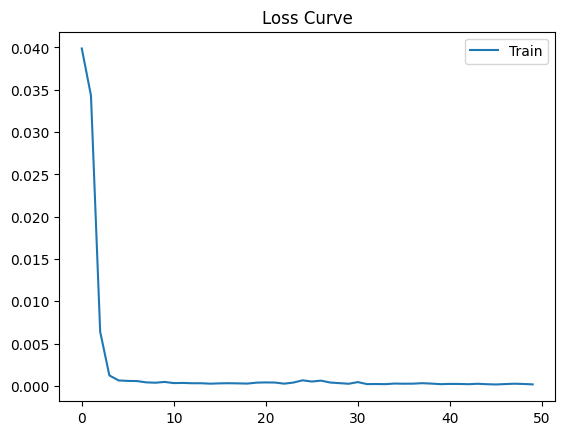

In [13]:
nvda_lstm = LSTMRegressor(
    input_dim=kan_params['encoded_dim'],
    hidden_dim=lstm_params['hidden_dim'],
    num_layers=lstm_params['num_layers'],
    dropout=lstm_params['dropout']
).to(device)

nvda_encoder = KANEncoder(
    width=[input_dim, kan_params['kan_hidden_dim'], kan_params['encoded_dim']],
    grid=kan_params['grid'],
    k=kan_params['k'],
    symbolic_enabled=False,
    affine_trainable=True,
    device=device,
    seed=SEED
).to(device)

optimizer = optim.Adam([
        {'params': nvda_encoder.parameters(), 'lr': kan_params['lr']},
        {'params': nvda_lstm.parameters(), 'lr': lstm_params['lr']}
    ])
criterion = nn.MSELoss()
train_losses = []

for epoch in range(50):
    nvda_encoder.train()
    nvda_lstm.train()
    train_loss = 0.0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        encoded = nvda_encoder(xb)
        preds = nvda_lstm(encoded).squeeze()
        mse_loss = criterion(preds, yb)

        reg = nvda_encoder.kan.get_reg(
            reg_metric="edge_forward_spline_n",
            lamb_l1=kan_params['lamb_l1'],
            lamb_entropy=kan_params['lamb_entropy'],
            lamb_coef=0.0,
            lamb_coefdiff=0.0
        )
        train_loss += mse_loss.item()
        total_loss = mse_loss + kan_params['lambda_reg'] * reg
        total_loss.backward()
        optimizer.step()

    train_loss /= len(train_dl)
    train_losses.append(train_loss)

    print(f"Epoch {epoch+1}: Train={train_loss}")#: Val={val_loss}")

plt.plot(train_losses, label='Train')
# plt.plot(val_losses, label='Val')
plt.legend()
plt.title("Loss Curve")
plt.show()

Test RMSE: 8.7486
Test MAE : 6.7109


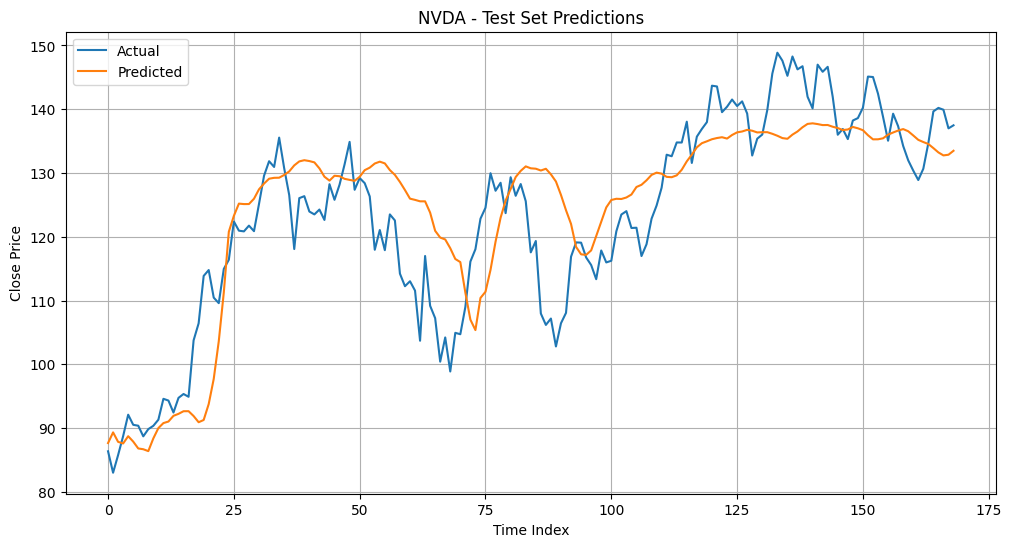

Actual Volatility (std of returns): 0.0328
Predicted Volatility             : 0.0149


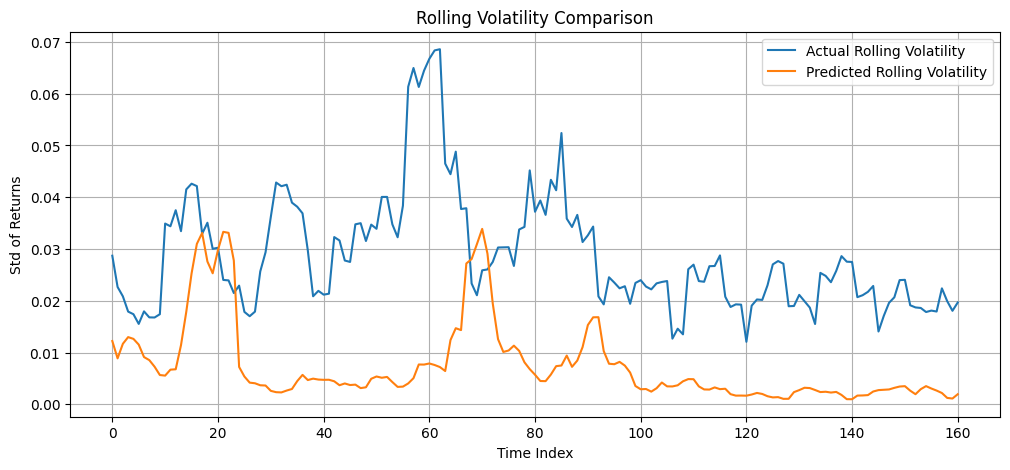

In [14]:
# Ensure both models are in eval mode
nvda_encoder.eval()
nvda_lstm.eval()

preds, targets = [], []

with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        encoded = nvda_encoder(xb)             # [B, T, D]
        pred = nvda_lstm(encoded).squeeze().cpu().numpy()
        preds.extend(pred)
        targets.extend(yb.numpy())

# Unscale predictions if needed
close_scaler = scalers[f"{stock.value}_Close"]
nvda_preds_unscaled = close_scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()
nvda_targets_unscaled = close_scaler.inverse_transform(np.array(targets).reshape(-1, 1)).flatten()

# Compute error metrics
rmse = np.sqrt(mean_squared_error(nvda_targets_unscaled, nvda_preds_unscaled))
mae = mean_absolute_error(nvda_targets_unscaled, nvda_preds_unscaled)

# Print metrics
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE : {mae:.4f}")

# Plot predictions vs actuals
plt.figure(figsize=(12, 6))
plt.plot(nvda_targets_unscaled, label="Actual")
plt.plot(nvda_preds_unscaled, label="Predicted")
plt.legend()
plt.title(f"{stock.value} - Test Set Predictions")
plt.xlabel("Time Index")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()

actual_returns = np.diff(nvda_targets_unscaled) / nvda_targets_unscaled[:-1]
pred_returns   = np.diff(nvda_preds_unscaled) / nvda_preds_unscaled[:-1]
actual_vol = np.std(actual_returns)
pred_vol   = np.std(pred_returns)

print(f"Actual Volatility (std of returns): {actual_vol:.4f}")
print(f"Predicted Volatility             : {pred_vol:.4f}")

window = 7  # rolling window in days

actual_vol_rolling = np.std([
    actual_returns[i:i+window] for i in range(len(actual_returns) - window)
], axis=1)

pred_vol_rolling = np.std([
    pred_returns[i:i+window] for i in range(len(pred_returns) - window)
], axis=1)

plt.figure(figsize=(12, 5))
plt.plot(actual_vol_rolling, label='Actual Rolling Volatility')
plt.plot(pred_vol_rolling, label='Predicted Rolling Volatility')
plt.title("Rolling Volatility Comparison")
plt.xlabel("Time Index")
plt.ylabel("Std of Returns")
plt.legend()
plt.grid(True)
plt.show()

### Apple ###
Avg Val Loss in Tuning 0.000254

In [6]:
stock = StockIndex.AAPL
lstm_params = BEST_LSTM_PARAMS[stock]
kan_params = BEST_KAN_PARAMS[stock]
train_dl, test_dl, scalers = get_data_loaders(stock, window_size, batch_size = lstm_params["batch_size"],
                                                      use_val_split=False)
input_dim = next(iter(train_dl))[0].shape[-1]

Epoch 1: Train=0.03815881391920178
Epoch 2: Train=0.0008997148593106881
Epoch 3: Train=0.0007861285709136289
Epoch 4: Train=0.0012923939821764244
Epoch 5: Train=0.0006076531039934248
Epoch 6: Train=0.0011346921948845396
Epoch 7: Train=0.0008406075535781889
Epoch 8: Train=0.0005061658376515043
Epoch 9: Train=0.0009210324460214869
Epoch 10: Train=0.0006236440373932698
Epoch 11: Train=0.0004646413018244949
Epoch 12: Train=0.00085378494619326
Epoch 13: Train=0.0005245834957653036
Epoch 14: Train=0.0005108264963244878
Epoch 15: Train=0.0005580386090459245
Epoch 16: Train=0.0006803758308641857
Epoch 17: Train=0.0008096814483658156
Epoch 18: Train=0.00038775042092752164
Epoch 19: Train=0.0008108877592174468
Epoch 20: Train=0.0006135869619843427
Epoch 21: Train=0.0005093337943003691
Epoch 22: Train=0.0005525663880028085
Epoch 23: Train=0.0003858895601517747
Epoch 24: Train=0.0005678879974628658
Epoch 25: Train=0.00040688063914657126
Epoch 26: Train=0.0007275498571812711
Epoch 27: Train=0.00039

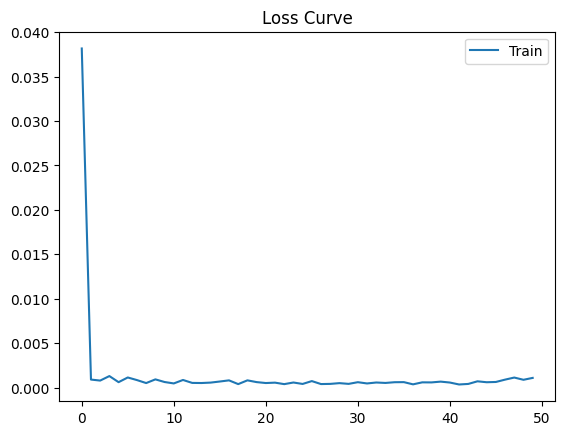

In [7]:
aapl_lstm = LSTMRegressor(
    input_dim=kan_params['encoded_dim'],
    hidden_dim=lstm_params['hidden_dim'],
    num_layers=lstm_params['num_layers'],
    dropout=lstm_params['dropout']
).to(device)

aapl_encoder = KANEncoder(
    width=[input_dim, kan_params['kan_hidden_dim'], kan_params['encoded_dim']],
    grid=kan_params['grid'],
    k=kan_params['k'],
    symbolic_enabled=False,
    affine_trainable=True,
    device=device,
    seed=SEED
).to(device)

optimizer = optim.Adam([
        {'params': aapl_encoder.parameters(), 'lr': kan_params['lr']},
        {'params': aapl_lstm.parameters(), 'lr': lstm_params['lr']}
    ])
criterion = nn.MSELoss()
train_losses = []

for epoch in range(50):
    aapl_encoder.train()
    aapl_lstm.train()
    train_loss = 0.0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        encoded = aapl_encoder(xb)
        preds = aapl_lstm(encoded).squeeze()
        mse_loss = criterion(preds, yb)

        reg = aapl_encoder.kan.get_reg(
            reg_metric="edge_forward_spline_n",
            lamb_l1=kan_params['lamb_l1'],
            lamb_entropy=kan_params['lamb_entropy'],
            lamb_coef=0.0,
            lamb_coefdiff=0.0
        )
        train_loss += mse_loss.item()
        total_loss = mse_loss + kan_params['lambda_reg'] * reg
        total_loss.backward()
        optimizer.step()

    train_loss /= len(train_dl)
    train_losses.append(train_loss)

    print(f"Epoch {epoch+1}: Train={train_loss}")#: Val={val_loss}")

plt.plot(train_losses, label='Train')
# plt.plot(val_losses, label='Val')
plt.legend()
plt.title("Loss Curve")
plt.show()

Test RMSE: 30.3484
Test MAE : 24.4624


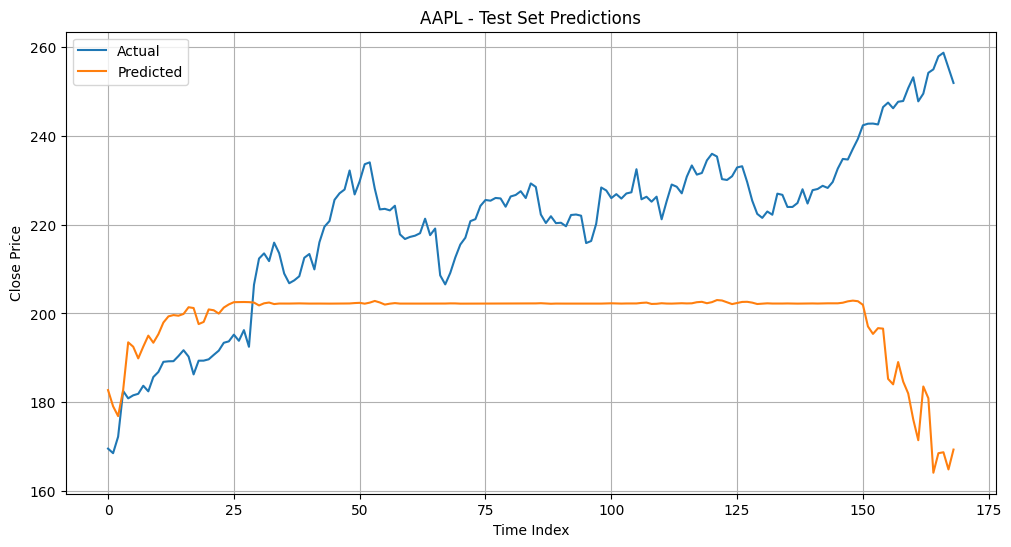

Actual Volatility (std of returns): 0.0145
Predicted Volatility             : 0.0133


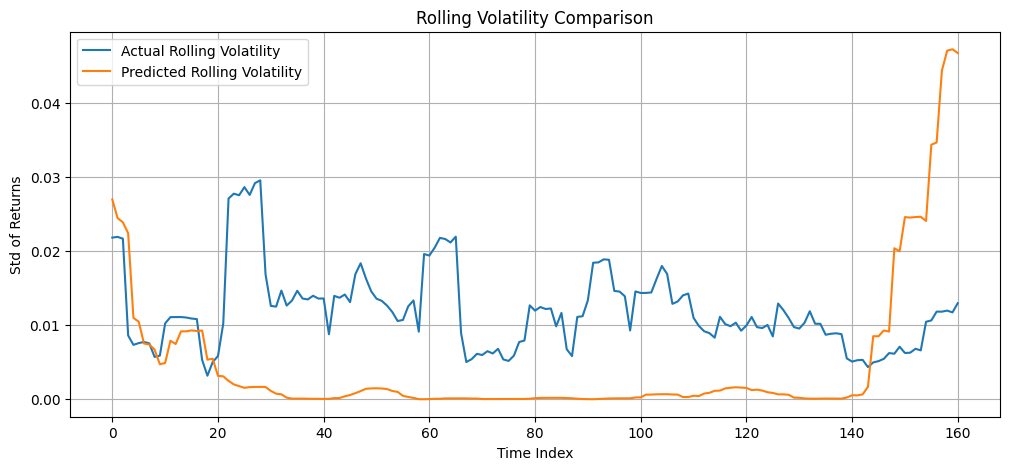

In [8]:
# Ensure both models are in eval mode
aapl_encoder.eval()
aapl_lstm.eval()

preds, targets = [], []

with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        encoded = aapl_encoder(xb)             # [B, T, D]
        pred = aapl_lstm(encoded).squeeze().cpu().numpy()
        preds.extend(pred)
        targets.extend(yb.numpy())

# Unscale predictions if needed
close_scaler = scalers[f"{stock.value}_Close"]
aapl_preds_unscaled = close_scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()
aapl_targets_unscaled = close_scaler.inverse_transform(np.array(targets).reshape(-1, 1)).flatten()

# Compute error metrics
rmse = np.sqrt(mean_squared_error(aapl_targets_unscaled, aapl_preds_unscaled))
mae = mean_absolute_error(aapl_targets_unscaled, aapl_preds_unscaled)

# Print metrics
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE : {mae:.4f}")

# Plot predictions vs actuals
plt.figure(figsize=(12, 6))
plt.plot(aapl_targets_unscaled, label="Actual")
plt.plot(aapl_preds_unscaled, label="Predicted")
plt.legend()
plt.title(f"{stock.value} - Test Set Predictions")
plt.xlabel("Time Index")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()

actual_returns = np.diff(aapl_targets_unscaled) / aapl_targets_unscaled[:-1]
pred_returns   = np.diff(aapl_preds_unscaled) / aapl_preds_unscaled[:-1]
actual_vol = np.std(actual_returns)
pred_vol   = np.std(pred_returns)

print(f"Actual Volatility (std of returns): {actual_vol:.4f}")
print(f"Predicted Volatility             : {pred_vol:.4f}")

window = 7  # rolling window in days

actual_vol_rolling = np.std([
    actual_returns[i:i+window] for i in range(len(actual_returns) - window)
], axis=1)

pred_vol_rolling = np.std([
    pred_returns[i:i+window] for i in range(len(pred_returns) - window)
], axis=1)

plt.figure(figsize=(12, 5))
plt.plot(actual_vol_rolling, label='Actual Rolling Volatility')
plt.plot(pred_vol_rolling, label='Predicted Rolling Volatility')
plt.title("Rolling Volatility Comparison")
plt.xlabel("Time Index")
plt.ylabel("Std of Returns")
plt.legend()
plt.grid(True)
plt.show()

### Coke ###
Avg Val Loss in Tuning 0.000351

In [9]:
stock = StockIndex.KO
lstm_params = BEST_LSTM_PARAMS[stock]
kan_params = BEST_KAN_PARAMS[stock]
train_dl, test_dl, scalers = get_data_loaders(stock, window_size, batch_size = lstm_params["batch_size"],
                                                      use_val_split=False)
input_dim = next(iter(train_dl))[0].shape[-1]

Epoch 1: Train=0.05370790560993206
Epoch 2: Train=0.002722189728184744
Epoch 3: Train=0.0019070653743439852
Epoch 4: Train=0.001640517438933573
Epoch 5: Train=0.0016672799585391814
Epoch 6: Train=0.0015620802149336522
Epoch 7: Train=0.001459947135181853
Epoch 8: Train=0.0015435424398729633
Epoch 9: Train=0.001324877724982798
Epoch 10: Train=0.0012994180994950273
Epoch 11: Train=0.0012154575379099697
Epoch 12: Train=0.0013170424796466837
Epoch 13: Train=0.0011429536248077497
Epoch 14: Train=0.0011529846880067554
Epoch 15: Train=0.0010899419524716307
Epoch 16: Train=0.001007619664170591
Epoch 17: Train=0.0011039563051055683
Epoch 18: Train=0.0009409417853939977
Epoch 19: Train=0.000945288005621276
Epoch 20: Train=0.0008867983512269954
Epoch 21: Train=0.0008838950339446051
Epoch 22: Train=0.0009337168528211557
Epoch 23: Train=0.0009459534164922631
Epoch 24: Train=0.0008218016558046914
Epoch 25: Train=0.0008791153021674189
Epoch 26: Train=0.000862591721633722
Epoch 27: Train=0.000748680257

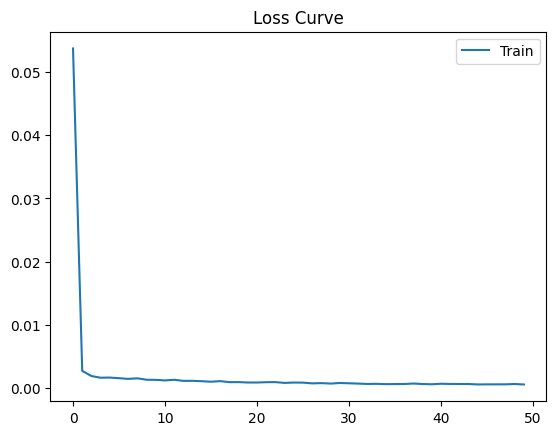

In [10]:
ko_lstm = LSTMRegressor(
    input_dim=kan_params['encoded_dim'],
    hidden_dim=lstm_params['hidden_dim'],
    num_layers=lstm_params['num_layers'],
    dropout=lstm_params['dropout']
).to(device)

ko_encoder = KANEncoder(
    width=[input_dim, kan_params['kan_hidden_dim'], kan_params['encoded_dim']],
    grid=kan_params['grid'],
    k=kan_params['k'],
    symbolic_enabled=False,
    affine_trainable=True,
    device=device,
    seed=SEED
).to(device)

optimizer = optim.Adam([
        {'params': ko_encoder.parameters(), 'lr': kan_params['lr']},
        {'params': ko_lstm.parameters(), 'lr': lstm_params['lr']}
    ])
criterion = nn.MSELoss()
train_losses = []
val_losses = []

best_val_loss = float("inf")
best_model_state = None

for epoch in range(50):
    ko_encoder.train()
    ko_lstm.train()
    train_loss = 0.0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        encoded = ko_encoder(xb)
        preds = ko_lstm(encoded).squeeze()
        mse_loss = criterion(preds, yb)

        reg = ko_encoder.kan.get_reg(
            reg_metric="edge_forward_spline_n",
            lamb_l1=kan_params['lamb_l1'],
            lamb_entropy=kan_params['lamb_entropy'],
            lamb_coef=0.0,
            lamb_coefdiff=0.0
        )
        train_loss += mse_loss.item()
        total_loss = mse_loss + kan_params['lambda_reg'] * reg
        total_loss.backward()
        optimizer.step()

    train_loss /= len(train_dl)
    train_losses.append(train_loss)

    print(f"Epoch {epoch+1}: Train={train_loss}")#: Val={val_loss}")

plt.plot(train_losses, label='Train')
# plt.plot(val_losses, label='Val')
plt.legend()
plt.title("Loss Curve")
plt.show()

Test RMSE: 5.9502
Test MAE : 4.7260


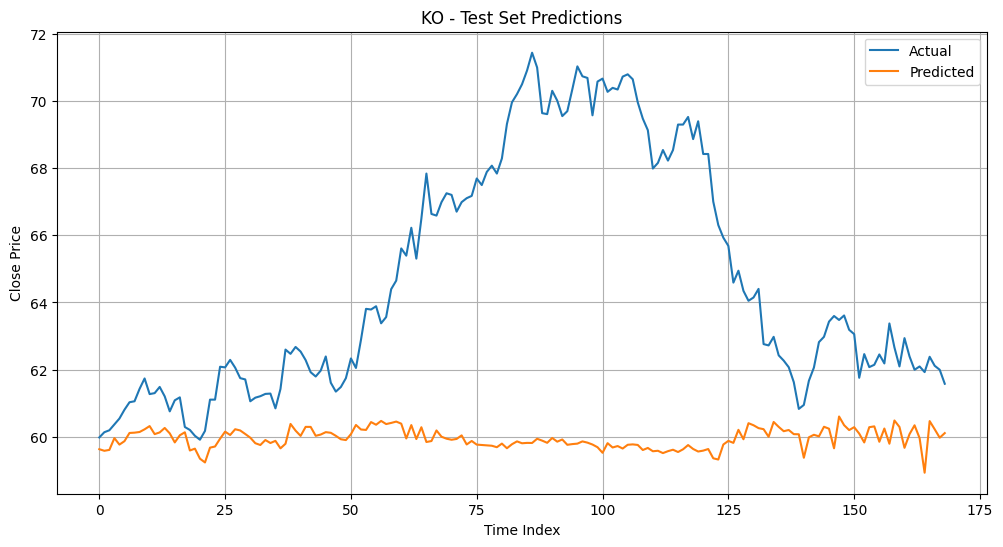

Actual Volatility (std of returns): 0.0083
Predicted Volatility             : 0.0046


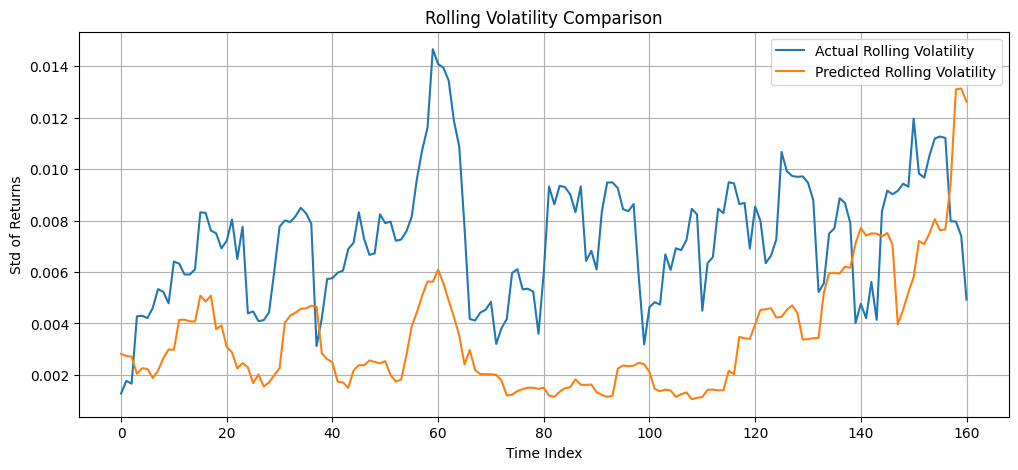

In [11]:
# Ensure both models are in eval mode
ko_encoder.eval()
ko_lstm.eval()

preds, targets = [], []

with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        encoded = ko_encoder(xb)             # [B, T, D]
        pred = ko_lstm(encoded).squeeze().cpu().numpy()
        preds.extend(pred)
        targets.extend(yb.numpy())

# Unscale predictions if needed
close_scaler = scalers[f"{stock.value}_Close"]
ko_preds_unscaled = close_scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()
ko_targets_unscaled = close_scaler.inverse_transform(np.array(targets).reshape(-1, 1)).flatten()

# Compute error metrics
rmse = np.sqrt(mean_squared_error(ko_targets_unscaled, ko_preds_unscaled))
mae = mean_absolute_error(ko_targets_unscaled, ko_preds_unscaled)

# Print metrics
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE : {mae:.4f}")

# Plot predictions vs actuals
plt.figure(figsize=(12, 6))
plt.plot(ko_targets_unscaled, label="Actual")
plt.plot(ko_preds_unscaled, label="Predicted")
plt.legend()
plt.title(f"{stock.value} - Test Set Predictions")
plt.xlabel("Time Index")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()

actual_returns = np.diff(ko_targets_unscaled) / ko_targets_unscaled[:-1]
pred_returns   = np.diff(ko_preds_unscaled) / ko_preds_unscaled[:-1]
actual_vol = np.std(actual_returns)
pred_vol   = np.std(pred_returns)

print(f"Actual Volatility (std of returns): {actual_vol:.4f}")
print(f"Predicted Volatility             : {pred_vol:.4f}")

window = 7  # rolling window in days

actual_vol_rolling = np.std([
    actual_returns[i:i+window] for i in range(len(actual_returns) - window)
], axis=1)

pred_vol_rolling = np.std([
    pred_returns[i:i+window] for i in range(len(pred_returns) - window)
], axis=1)

plt.figure(figsize=(12, 5))
plt.plot(actual_vol_rolling, label='Actual Rolling Volatility')
plt.plot(pred_vol_rolling, label='Predicted Rolling Volatility')
plt.title("Rolling Volatility Comparison")
plt.xlabel("Time Index")
plt.ylabel("Std of Returns")
plt.legend()
plt.grid(True)
plt.show()